# Projeto #4: Classificação de texto

# Tarefa e Dados


<p align="justify">Descreva a tarefa escolhida e os dados. Escreva o código que leia os dados e calcule e imprima quantas instâncias os dados têm. Também, seu código deve calcular a média de tokens por instância, isto é, quantos tokens, na média cada documento do seu conjunto de dados possui. Imprima esse único número.</p>

### Base de dados escolhida:

<p align="justify">A base escolhida foi a <b>UTL Corpus</b> que é um conjunto de dados, em português, que contém críticas de filmes e apps coletadas automaticamente de sites.</p>

- **Nome da base**: UTLCorpus
- **Link do drive**: https://drive.google.com/file/d/1vSlDdOIYshNvCyRsZfw_qTmvwlTiS_JG/view?usp=sharing
- **Repositório**: https://github.com/RogerFig/UTLCorpus
- **Artigo de referência**: https://repositorio.usp.br/item/002971317

<p align="justify">Esse corpus é uma coleção de resenhas extraídas de dois domínios: filmes e aplicativos. A base possui 15 atributos e 2.881.589 avaliações sendo 1.839.851 de filmes e 1.041.738 de aplicativos. O domínio utilizado nesse projeto será o de <b>aplicativos</b> e a tarefa será <b>classificação</b> binária cujo objetivo será dizer se uma avaliação é positiva ou negativa.</p>

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


### Bibliotecas básicas

In [2]:
!pip install spellchecker
!pip install pyspellchecker
!pip install scattertext
!python -m spacy download pt_core_news_sm
!pip install -U yellowbrick

✔ Download and installation successful
You can now load the model via spacy.load('pt_core_news_sm')
Requirement already up-to-date: yellowbrick in /usr/local/lib/python3.6/dist-packages (1.2)


In [3]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [4]:
import numpy as np
import pandas as pd

import warnings
warnings.filterwarnings('ignore')

%run '/content/gdrive/MyDrive/Colab Notebooks/aed_projeto_4/modules/data.py'

print(f'Versão Pandas: {pd.__version__}')
print(f'Versão Numpy: {np.__version__}')

pd.set_option('display.float_format', lambda x: '%.3f' % x);

Versão Pandas: 1.1.4
Versão Numpy: 1.18.5


### Bibliotecas de visualização

In [5]:
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt

%matplotlib inline
matplotlib.style.use(['ggplot'])

print(f'Versão Seaborn: {sns.__version__}')
print(f'Versão Matplotlib: {matplotlib.__version__}')

Versão Seaborn: 0.11.0
Versão Matplotlib: 3.2.2


In [6]:
plt.rcParams['axes.facecolor']='white'
plt.rcParams['font.family'] = 'Arial, Helvetica, sans-serif'

### Dicionário dos dados

**domain**: domínio das resenhas

**object**: aplicativo avaliado

**author**: autor da avaliação (anonimizado)

**text**: texto da avaliação

**likes**: número de likes que a avaliação recebeu

**unlikes**: número de deslikes que a avaliação recebeu

**stars**: número de estrelas dada na avaliação

**date**: data da avaliação

**internal_id**: identificador

### Carregamento dos dados

In [7]:
data = pd.read_csv('/content/gdrive/MyDrive/Colab Notebooks/aed_projeto_4/data/UTLCorpus.csv')
print(f'Linhas: {data.shape[0]} | Colunas: {data.shape[1]}')

Linhas: 2881589 | Colunas: 16


### Escolha do domínio

In [8]:
apps = data.query('domain=="apps"')
apps.drop(['Unnamed: 0', 'replies', 'favorite', 'want_see', 'recommend', 'see', 'collect_date'], axis=1, inplace=True)
apps.reset_index(drop=True, inplace=True)
print(f'Linhas: {apps.shape[0]} | Colunas: {apps.shape[1]}')

Linhas: 1041738 | Colunas: 9


### Características dos dados

In [9]:
apps.head()

,domain,object,author,text,likes,unlikes,stars,date,internal_id
0,apps,air.com.hypah.io.slither,0,"Adorei, podia melhorar em vários detalhes, por...",1100,0,5.000,22 de janeiro de 2019,0
1,apps,air.com.hypah.io.slither,1,"17 de março, estamos no ps4 jogando r6, e talv...",152,0,5.000,17 de março de 2019,1
2,apps,air.com.hypah.io.slither,2,É um jogo bom hzbsbbsbdjdjkaklloosjbsbzbsbhhHA...,0,0,5.000,3 de março de 2019,2
3,apps,air.com.hypah.io.slither,3,O jogo e mais o menos um pouco bom só que ele ...,0,0,2.000,1 de abril de 2019,3
4,apps,air.com.hypah.io.slither,4,0. JOGO. E. MUITO. CHATO. MAIS. E. RASUAVEL. V...,0,0,2.000,6 de abril de 2019,4


In [10]:
print(f'Colunas presentes: {apps.columns.values}')

Colunas presentes: ['domain' 'object' 'author' 'text' 'likes' 'unlikes' 'stars' 'date'
 'internal_id']


In [11]:
print(f'Tipos dos dados: {apps.dtypes.unique()}')

Tipos dos dados: [dtype('O') dtype('int64') dtype('float64')]


### Informação dos dados

In [12]:
apps.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1041738 entries, 0 to 1041737
Data columns (total 9 columns):
 #   Column       Non-Null Count    Dtype  
---  ------       --------------    -----  
 0   domain       1041738 non-null  object 
 1   object       1041738 non-null  object 
 2   author       1041738 non-null  int64  
 3   text         1039542 non-null  object 
 4   likes        1041738 non-null  int64  
 5   unlikes      1041738 non-null  int64  
 6   stars        1041738 non-null  float64
 7   date         1041738 non-null  object 
 8   internal_id  1041738 non-null  int64  
dtypes: float64(1), int64(4), object(4)
memory usage: 71.5+ MB


### Descrição dos dados

In [13]:
apps.drop(['author', 'internal_id'], axis=1).describe()

,likes,unlikes,stars
count,1041738.000,1041738.000,1041738.000
mean,6.016,0.000,3.957
std,86.191,0.000,1.528
min,0.000,0.000,0.000
25%,0.000,0.000,3.000
50%,0.000,0.000,5.000
75%,0.000,0.000,5.000
max,20146.000,0.000,5.000


In [14]:
apps[['object', 'text', 'date']].describe(include='O')

,object,text,date
count,1041738,1039542,1041738
unique,233,809232,2879
top,br.com.vivo,muito bom,29 de março de 2019
freq,5080,17946,16863


### Valores nulos

In [15]:
data_missing = pd.DataFrame({'nomes': apps.columns, 
                             'tipos': apps.dtypes, 
                             'NA #': apps.isna().sum(),
                             'NA %': (apps.isna().sum() / apps.shape[0]) * 100
                            })

data_missing[data_missing['NA #'] > 0].set_index('nomes')

,tipos,NA #,NA %
nomes,,,
text,object,2196,0.211


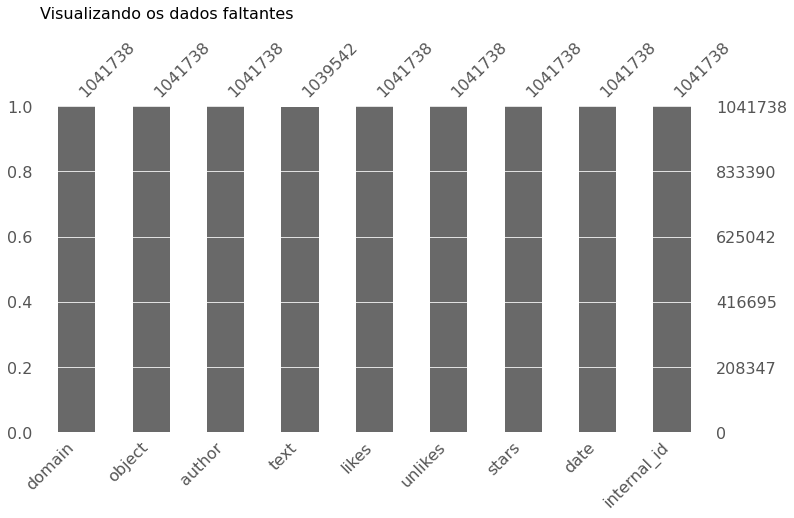

In [16]:
import missingno as msno

msno.bar(apps, figsize=[12, 6])
plt.title('Visualizando os dados faltantes', y=1.25, size=16, loc='left')
plt.show()

#### Remoção das linhas com texto nulos

In [17]:
apps.dropna(inplace=True)
print('Conferindo a remoção dos valores nulos: ')
apps.isna().sum()

Conferindo a remoção dos valores nulos: 


domain         0
object         0
author         0
text           0
likes          0
unlikes        0
stars          0
date           0
internal_id    0
dtype: int64

### Definição dos rótulos

<p align='justify'>Cada crítica tem uma pontuação de 0 a 5 estrelas:</p>

- 0 e 5: serão descartadas para evitar os casos em que as estrelas do usuário não são coerentes com o texto da avaliação.
 
- 1 e 2: negativa

- 3: serão descartadas, porque geralmente contêm opiniões positivas e negativas.

- 4: positiva

<p align='justify'>Baseada na metodologia explicada neste artigo: <a href='https://www.teses.usp.br/teses/disponiveis/55/55134/tde-24032016-171420/pt-br.php'>Sobre normalização e classificação de polaridade de textos opinativos na web</a></p>

#### Distribuição das estrelas

In [18]:
apps['stars'].value_counts()

5.000    632365
1.000    170877
4.000    118379
3.000     70677
2.000     47237
0.000         7
Name: stars, dtype: int64

#### Exemplo de opinião negativa e positiva no mesmo texto

In [19]:
print(apps[apps.index==92][['text', 'stars']].values[0])

['O jogo é bom, mas ele tem muita propaganda e além disso ele trava demais'
 3.0]


#### Exemplo de texto em que a estrela do usuário não é coerente com o texto

In [20]:
print(apps[apps.index==319073][['text', 'stars']].values[0])

['Gostei, acompanho vários esportes no msm lugar. Funfa muito bem no Galaxy S'
 0.0]


#### Seleção das classificações com 1, 2 e 4 estrelas

In [21]:
apps = apps.query('stars==1 or stars==2 or stars==4')
apps.reset_index(drop=True, inplace=True)
print(f'Linhas: {apps.shape[0]} | Colunas: {apps.shape[1]}')

Linhas: 336493 | Colunas: 9


#### Criação dos rótulos para as classificações

In [22]:
labels_map = {1 : 'negativo', 2: 'negativo', 4: 'positivo'}
apps['rating'] = apps['stars'].map(labels_map)
apps['rating'].value_counts()

negativo    218114
positivo    118379
Name: rating, dtype: int64

### Exemplos dos textos

In [23]:
printExample(4, apps)

Text: Eu quero que arrume tem muito comerciais falças quando você acaba de perde quando você sai ai tem comerciais eu ficou unvido musica com esse jogo quando chegar outro comeciau ele pausa a musica
Rating: negativo
Stars: 1.0


In [24]:
printExample(0, apps)

Text: O jogo e mais o menos um pouco bom só que ele fica travando muito no meu celula ñ curti muito mais dou duas estrelas
Rating: negativo
Stars: 2.0


In [25]:
printExample(2, apps)

Text: sabe o jogo é muito bom tem feito um sucesso imenso, não quero choramingar mas quando a gente esta no nível supremo e alguem mata vc é de ficar puto da vida
Rating: positivo
Stars: 4.0


### Amostragem dos dados

<p align='justify'>Devido ao custo computacional, será usada apenas uma amostra 70.000 dados.</p>

In [26]:
apps = apps.groupby(['rating']).apply(lambda x : x.sample(n=35000, replace=False))
apps.reset_index(drop=True, inplace=True)
print(apps['rating'].value_counts())

positivo    35000
negativo    35000
Name: rating, dtype: int64


### Limpeza dos dados

In [27]:
# from tqdm import tqdm

# for text in tqdm(apps['text']):
#     apps['text'] = apps['text'].apply(cleaning)
    
# apps.to_csv('data/data_cleaned.csv', index=False)

### Dados pré-processados

In [28]:
apps = pd.read_csv('/content/gdrive/MyDrive/Colab Notebooks/aed_projeto_4/data/data_cleaned.csv')
print(f'Linhas: {apps.shape[0]} | Colunas: {apps.shape[1]}')

Linhas: 70000 | Colunas: 11


### Seleção de features

In [29]:
apps = apps.drop(['text', 'author', 'date', 'internal_id', 'likes', 'object', 'stars', 'unlikes', 'domain'], axis=1)
print(f'Linhas: {apps.shape[0]} | Colunas: {apps.shape[1]}')

Linhas: 70000 | Colunas: 2


### Embaralhamento dos dados

In [30]:
apps = apps.iloc[np.random.permutation(apps.index)].reset_index(drop=True)

### Análise N-grams

#### Unigrams

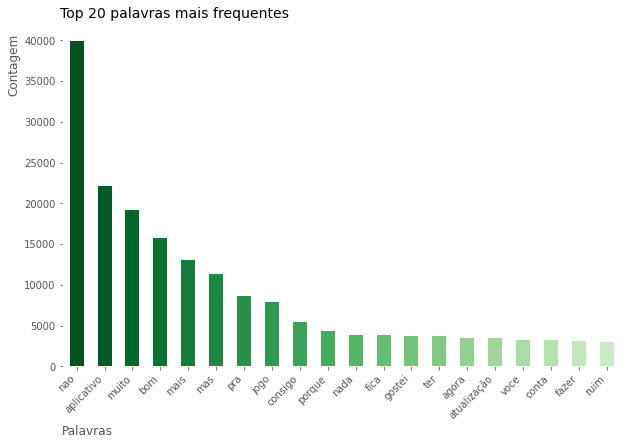

In [31]:
common_words = getTopNwords(apps['clean_text'])
uni = pd.DataFrame(common_words, columns = ['texto' , 'contagem'])

_, ax= plt.subplots()
uni.groupby('texto').sum()['contagem'].sort_values(ascending=False).plot(kind='bar', 
                                                                         color=sns.color_palette('Greens_r', n_colors=25), 
                                                                         figsize=[10, 6])

plt.title('Top 20 palavras mais frequentes', y=1.05, size=14, loc='left', x=-0.005)
plt.ylabel('Contagem', horizontalalignment='left', y=0.83)
plt.xlabel('Palavras', horizontalalignment='right', x=0.09)  
plt.ylim(0, 40000)
ax.set_xticklabels(uni['texto'], rotation=45, ha='right')
plt.show()

#### Bigrams

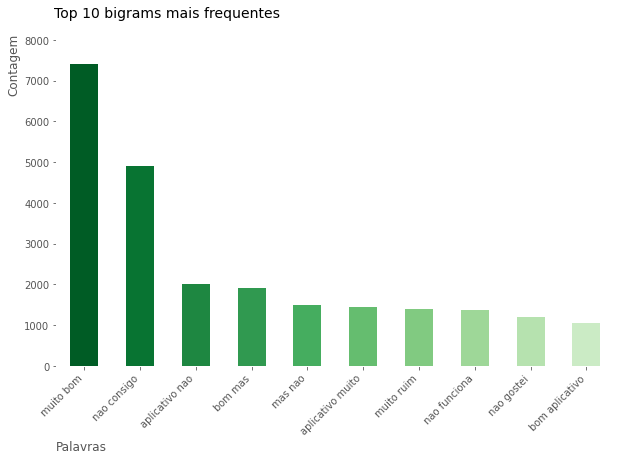

In [32]:
common_words = getTopNwords(apps['clean_text'], 2, 10)
bi = pd.DataFrame(common_words, columns = ['texto' , 'contagem'])

_, ax= plt.subplots()
bi.groupby('texto').sum()['contagem'].sort_values(ascending=False).plot(kind='bar', 
                                                                         color=sns.color_palette('Greens_r', n_colors=12), 
                                                                         figsize=[10, 6])

plt.title('Top 10 bigrams mais frequentes', y=1.05, size=14, loc='left', x=-0.005)
plt.ylabel('Contagem', horizontalalignment='left', y=0.83)
plt.xlabel('Palavras', horizontalalignment='right', x=0.09)  
plt.ylim(0, 8000)
ax.set_xticklabels(bi['texto'], rotation=45, ha='right')
plt.show()

#### Trigrams

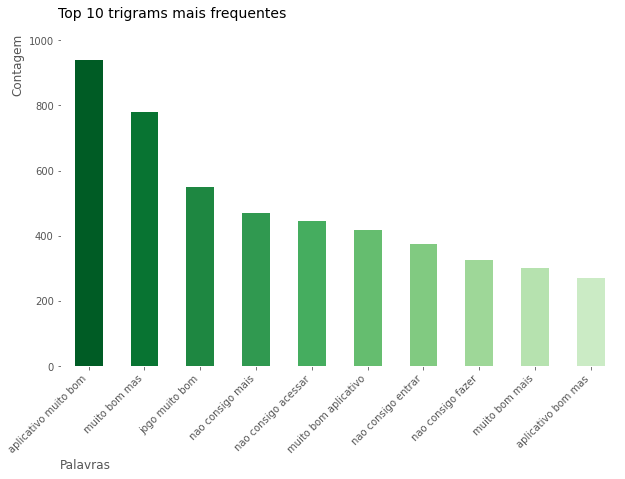

In [33]:
common_words = getTopNwords(apps['clean_text'], 3, 10)
tri = pd.DataFrame(common_words, columns = ['texto' , 'contagem'])

_, ax= plt.subplots()
tri.groupby('texto').sum()['contagem'].sort_values(ascending=False).plot(kind='bar', 
                                                                         color=sns.color_palette('Greens_r', n_colors=12), 
                                                                         figsize=[10, 6])

plt.title('Top 10 trigrams mais frequentes', y=1.05, size=14, loc='left', x=-0.005)
plt.ylabel('Contagem', horizontalalignment='left', y=0.83)
plt.xlabel('Palavras', horizontalalignment='right', x=0.09)  
plt.ylim(0, 1000)
ax.set_xticklabels(tri['texto'], rotation=45, ha='right')
plt.show()

### Encontrando termos característicos e suas associações

In [34]:
import scattertext as st
import spacy

nlp = spacy.load('pt_core_news_sm')
corpus = st.CorpusFromPandas (apps, category_col='rating', text_col='clean_text', nlp=nlp).build()

#### Termos mais característicos do corpus

In [35]:
print(list(corpus.get_scaled_f_scores_vs_background().index[:50]))

['aplicativo', 'nao', 'muito', 'jogo', 'bom', 'consigo', 'pra', 'gostei', 'mais', 'porque', 'ruim', 'fica', 'conta', 'otimo', 'trava', 'vezes', 'vou', 'horrivel', 'erro', 'estrelas', 'fazer', 'melhor', 'porem', 'voce', 'ainda', 'funciona', 'tudo', 'voces', 'celular', 'aparece', 'atualizar', 'bem', 'poderia', 'pois', 'agora', 'lixo', 'sempre', 'problema', 'melhorar', 'assim', 'nada', 'jogar', 'recomendo', 'acho', 'usar', 'entrar', 'gosto', 'coisa', 'deveria', 'quero']


#### Termos mais associados à classe negativo

In [36]:
term_freq_df = corpus.get_term_freq_df() 
term_freq_df['negativo'] = corpus.get_scaled_f_scores('negativo') 
print(list(term_freq_df.sort_values(by='negativo', ascending=False).index[:10]))

['bosta', 'nao recomendo', 'péssimo', 'péssimo aplicativo', 'pior aplicativo', 'lixo', 'odiei', 'nao presta', 'horrivel', 'aplicativo horrivel']


#### Termos mais associados à classe positivo

In [37]:
term_freq_df['positivo'] = corpus.get_scaled_f_scores('positivo') 
print(list(term_freq_df.sort_values(by='positivo', ascending=False).index[:10]))

['gostei bastante', 'bom recomendo', 'facil usar', 'muito pratico', 'nao dei', 'bom gostei', 'mas poderia', 'bem legal', 'muito bom', 'bom aplicativo']


### Média de tokens por instância

In [39]:
average = averageTokens(apps, 'clean_text')
print(f'Média dos tokens por instância: {round(average, 2)}')

Média dos tokens por instância: 11.1


### Encoder

In [40]:
X = apps.drop(['rating'], axis=1)
y = apps['rating']

In [41]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y = le.fit_transform(y)
print('Labels: ', len(le.classes_))

Labels:  2


### Separação treino e teste

In [42]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=85, shuffle=True)

# Representação

<p align="justify">Você vai usar cada uma dessas representações e compará-las. A seguir temos a listagem das representações que devem ser usadas para representar seu texto:</p>

- Representação TF-IDF
- Representação com o word2vec
- Extração de features do texto

#### TF-IDF

In [43]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

vectorizer = TfidfVectorizer(stop_words=STOPWORDS)
vectors = vectorizer.fit_transform(X_train['clean_text'])

standard = StandardScaler(with_mean=False)
vectors = standard.fit_transform(vectors)

#### Word2vec

In [44]:
from gensim.models import KeyedVectors
model_w2v = KeyedVectors.load_word2vec_format('/content/gdrive/MyDrive/Colab Notebooks/aed_projeto_4/model/vectors-wikipt.bin', binary= True)
model_w2v.init_sims(replace=True)

#### Extração de features do texto

In [45]:
from textblob import TextBlob

apps['polarity'] = apps['clean_text'].map(lambda text: TextBlob(text).sentiment.polarity)
apps['tamanho_texto'] = apps['clean_text'].astype(str).apply(len)
apps['contagem_palavras'] = apps['clean_text'].apply(lambda x: len(str(x).split()))

# Visualização dos dados
<p align="justify">Coloque nesta seção os gráficos do PCA e do t-SNE, para cada representação. Responda também às seguintes perguntas:</p>


- a) Existe algum padrão com relação às classes? 
- b) Caso exista algum padrão, você pode concluir alguma coisa? 
- c) Caso não exista, você consegue dizer se isso tem a ver com alguma representação ou classe?

**Observação:** Devido ao alto consumo de memória e da limitação do Colab e da minha máquina, será utilizada apenas uma amostra para gerar os gráficos PCA e T-SNE.

### PCA

#### TF-IDF

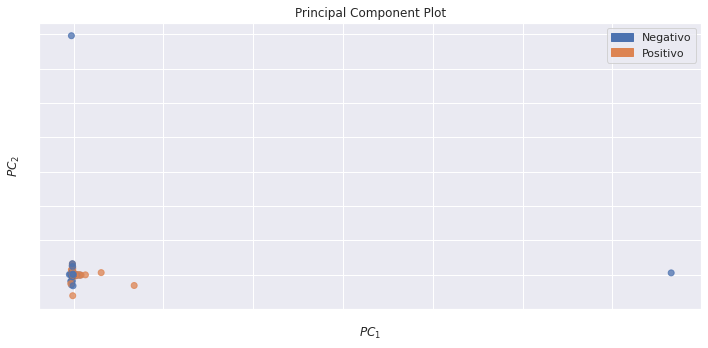

In [46]:
from yellowbrick.features import PCA

sns.set()

fig, ax = plt.subplots(figsize=(10, 5))
classes = ['Negativo', 'Positivo']

visualizer = PCA(scale=True, classes=classes)
visualizer.fit_transform(vectors.toarray()[:1000], y_train[:1000])
visualizer.show();

#### Word2vec

#### Extração de features

### T-SNE

#### TF-IDF

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


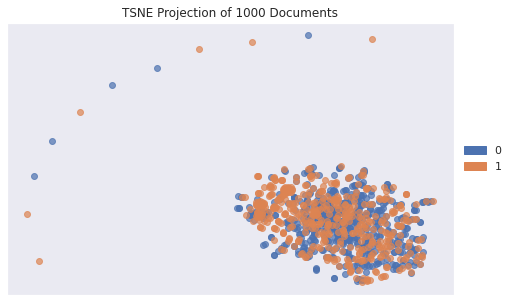

In [47]:
from yellowbrick.text import TSNEVisualizer

fig, ax = plt.subplots(figsize=(10, 5))
tsne = TSNEVisualizer(labels=[0, 1])
tsne.fit(vectors.toarray()[:1000], y_train[:1000])
tsne.show();

#### Word2vec

#### Extração de features

# Classificadores


<p align="justify">Descreva sucintamente os dois classificadores escolhidos. Você usou algum parâmetro que não seja padrão? Se sim, mencione nesta seção.</p>

# Resultados


<p align="justify">Escreva código que execute a validação cruzada em 5-folds para os dois classificadores escolhidos. Também responda às seguintes perguntas:</p>

- Os embeddings realmente mostraram um resultado melhor que o TF-IDF? 
- Se não, qual foi a representação que teve o melhor desempenho? 
- A diferença foi muito grande?

# Conclusão


<p align="justify">Por fim, fale aqui o que você conclui das visualizações e dos resultados. Tente explicar em detalhes por que um resultado, na sua opinião, foi melhor do que outro. Esta explicação pode incluir hipóteses para resultados melhores ou resultados piores. Também pode falar das dificuldades enfrentadas durante o trabalho e como conseguiu contorná-las.</p>